# Libraries

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mcubes
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from dataset import AllCTsDataset

# Postprocessing

## Get image

In [4]:
dataset = AllCTsDataset(
    root_dir='../data/allcts-051-512-cube/',
    metadata_name='metadata.csv',
    split='test',
    binarize=True,
    qs=[5]
)

In [5]:
idx = 0
dataset.df.iloc[idx, :]

name         CTS005
info              *
split          test
quality_5         1
Name: 5, dtype: object

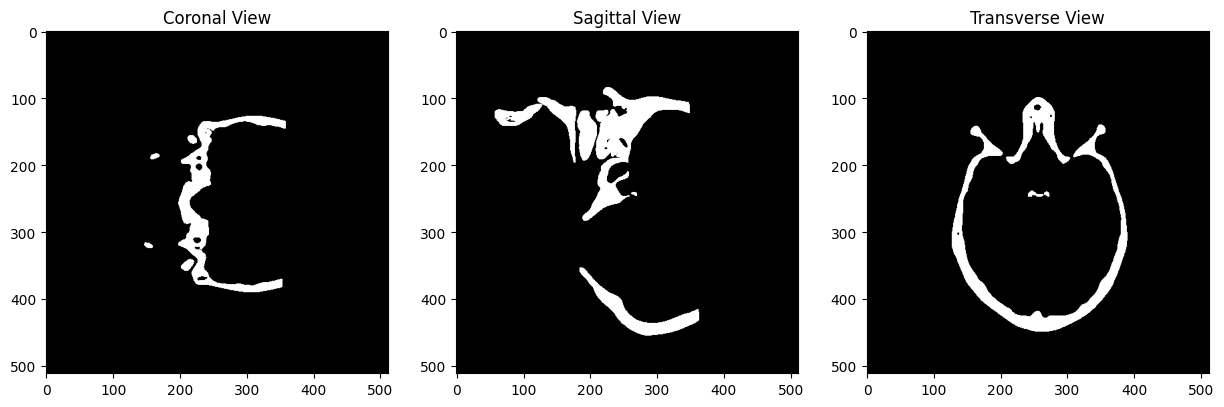

In [6]:
data = dataset[idx]['data'][0]

# Plot the middle slice from different perspectives
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

slice_idx = [d//2 + 10 for d in data.shape]

# Coronal view (frontal plane)
axs[0].imshow(data[slice_idx[0], :, :], cmap='Greys_r')
axs[0].set_title('Coronal View')

# Sagittal view (saggital plane)
axs[1].imshow(data[:, slice_idx[1], :], cmap='Greys_r')
axs[1].set_title('Sagittal View')

# Transverse view (horizontal plane)
axs[2].imshow(data[:, :, slice_idx[2]], cmap='Greys_r')
axs[2].set_title('Transverse View')


# Show the plot
plt.show()

## Postprocessing function
 (taken from dataset.utils.py)

In [7]:
# Build mesh from voxel grid
def build_mesh(voxels, threshold=0.5, name='mesh', output_folder=None, spacing=[0.51, 0.51, 0.51], smooth=False, rotate=True, translate=(0,0,0)):
    if rotate:
        voxels = np.rot90(voxels, k=1, axes=(0,1))

    if smooth:
        voxels = mcubes.smooth(voxels)
    
    vertices, triangles = mcubes.marching_cubes(voxels, threshold)

    # Scale the vertices according to the actual voxel spacing
    vertices = vertices * np.array(spacing)

    mesh = o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(vertices), triangles=o3d.utility.Vector3iVector(triangles))
    mesh = mesh.translate((translate))

    print(mesh)
    
    mesh.compute_vertex_normals()

    if output_folder is not None:
        output_folder = os.path.join(output_folder, name + '.stl')
        o3d.io.write_triangle_mesh(output_folder, mesh)
    else:
        o3d.visualization.draw_geometries([mesh])

In [13]:
def build_mesh_dae(voxels, threshold=0.5, name='mesh', output_folder=None, spacing=[0.51, 0.51, 0.51], smooth=False, rotate=True, translate=(0,0,0)):
    if rotate:
        voxels = np.rot90(voxels, k=1, axes=(0,1))

    if smooth:
        voxels = mcubes.smooth(voxels, 'constrained')
    
    vertices, triangles = mcubes.marching_cubes(voxels, threshold)

    # Scale the vertices according to the actual voxel spacing
    vertices = vertices * np.array(spacing)

    mcubes.export_mesh(vertices, triangles, os.path.join(output_folder, name + '.dae'), mesh_name=name)

## Mesh reconstruction

In [9]:
output_folder = '../data/mesh-postprocessing/'

In [10]:
# build_mesh(data, name=dataset.df.name.iloc[idx] + '-smooth-nospacing', output_folder=output_folder, smooth=True, threshold=0, spacing=[1,1,1])

In [ ]:
build_mesh_dae(data, name=dataset.df.name.iloc[idx] + '-smooth', output_folder=output_folder, smooth=True, threshold=0)